# POS-Tagging mit maschinellen Lernverfahren

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Trainings- und Testdaten

Trainings (`_train`) und Testdaten (`_dev`) laden. Da die TSV-Tabellen keine Kopfzeile haben, müssen wir sinnvolle Spaltennamen selbst festlegen. Wichtig ist dabei, dass Anführungszeichen als normale Zeichen gelesen (`quoting=3`) und `null`, `N/A` usw. nicht als undefinierte Werte interpretiert werden (sehr unintuitiv mit `keep_default_na=False`).

In [2]:
header = ("sent", "tok", "word", "pos", "lemma", "morph")
train = pd.read_csv("data/tiger2_train.tsv.gz", sep="\t", names=header, quoting=3, keep_default_na=False)
test = pd.read_csv("data/tiger2_dev.tsv.gz",sep="\t",names=header, quoting=3, keep_default_na=False)

In [3]:
train

,sent,tok,word,pos,lemma,morph
0,1,1,``,$(,--,{}
1,1,2,Ross,NE,Ross,"{""case"": ""nom"", ""number"": ""sg"", ""gender"": ""masc""}"
2,1,3,Perot,NE,Perot,"{""case"": ""nom"", ""number"": ""sg"", ""gender"": ""masc""}"
3,1,4,wäre,VAFIN,sein,"{""number"": ""sg"", ""person"": ""3"", ""tense"": ""past..."
4,1,5,vielleicht,ADV,vielleicht,{}
...,...,...,...,...,...,...
449280,25000,10,``,$(,--,{}
449281,25000,11,wäre,VAFIN,sein,"{""number"": ""sg"", ""person"": ""3"", ""tense"": ""past..."
449282,25000,12,Zensur,NN,Zensur,"{""case"": ""nom"", ""number"": ""sg"", ""gender"": ""fem""}"
449283,25000,13,'',$(,--,{}


Wir benötigen nur die ersten 4 Spalten (`lemma` und `morph` können wir später für andere Aufgaben nutzen).

In [4]:
train = train.iloc[:, 0:4]
test = test.iloc[:, 0:4]

Strings werden in Pandas als Arrays vom Typ `object` eingelesen.  Wir können sie explizit in spezielle `StringArray`s konvertieren, die aber [momentan wohl noch keine besonderen Performance-Vorteile](https://pandas.pydata.org/docs/user_guide/text.html) bieten.

In [5]:
train.word = train.word.astype('string')
train.pos  = train.pos.astype('string')
test.word  = test.word.astype('string')
test.pos   = test.pos.astype('string')
train.dtypes

sent     int64
tok      int64
word    string
pos     string
dtype: object

## Unigramm-Tagger (ohne Kontext)

Wir implementieren zunächst einen Unigramm-Tagger, der nur auf Wortformen arbeitet und keine Kontextinformation hinzuzieht. Das lässt sich besonders einfach mit der Pandas-Repräsentation der Trainingsdaten umsetzen.

Das naheliegendste Merkmal sind die Wortformen selbst, für die wir ein Dummy Coding (_one-hot encoding_) erstellen müssen.  Dies lässt sich direkt mit dem `OneHotEncoder` erstellen (oder dem `DictVectorizer`, der aber wesentlich mehr Overhead produziert).  Ein besonders einfacher und flexibler Ansatz ist ein `CountVectorizer`, der jeweils nur ein Token als Eingabe bekommt und viele weitere Optionen anbietet.  Wir vergleichen hier die Verarbeitungsgeschwindigkeit aller drei Varianten.

**1) OneHotEncoder:** Erwartet Listen oder Tupeln von Merkmalswerten, die jeweils in ein _one-hot encoding_ überführt werden. Hier müssen wir die Wörter also in Tupel der Länge 1 transformieren. Die Option `handle_unknown` muss auf `'ignore'` gesetzt werden, damit unbekannte Wortformen in den Testdaten keinen Fehler werfen. Mit `min_frequency` und `'infrequent_if_exist'` kann eine OOV-Kodierung implementiert werden. Wir setzen hier eine Schwellenwert von $f \ge 5$ an, damit nur halbwegs zuverlässige Lexikoninformation gelernt wird.

In [6]:
wf_vectorizer = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=5)
%time X_wf = wf_vectorizer.fit_transform([(x,) for x in train.word])
%time testX_wf = wf_vectorizer.transform([(x,) for x in test.word])
X_wf.shape

CPU times: user 660 ms, sys: 34.1 ms, total: 694 ms
Wall time: 698 ms
CPU times: user 226 ms, sys: 10.2 ms, total: 236 ms
Wall time: 236 ms


(449285, 8683)

**2) DictVectorizer:** Hier stehen keine Optionen zur Auswahl, insbesondere könnte ein Schwellenwert wie $f\ge 5$ nur als zusätzliche Transformation der Merkmalsmatrix umgesetzt werden. Obwohl als Eingabe eine Liste von Dictionaries erstellt werden muss, ist dieser Ansatz schneller als der OneHotEncoder.

In [7]:
wf_vectorizer = DictVectorizer()
%time X_wf = wf_vectorizer.fit_transform([{"word": x} for x in train.word])
%time testX_wf = wf_vectorizer.transform([{"word": x} for x in test.word])
X_wf.shape

CPU times: user 446 ms, sys: 24.1 ms, total: 470 ms
Wall time: 470 ms
CPU times: user 189 ms, sys: 7.92 ms, total: 197 ms
Wall time: 197 ms


(449285, 55803)

**3) CountVectorizer:** Wir können das _one-hot encoding_ auch mit einem `CountVectorizer` erzeugen, der jede Wortform als ein einzelnes Token behandelt (was durch einen geeigneten Custom-Tokenizer sichergestellt werden muss). Mit `binary=True` könnten wir auch explizit erzwingen, dass eine binäre Matrix erzeugt wird. Der Schwellenwert $f\ge 5$ lässt sich leicht mit `min_df` anwenden (in der Binärmatrix ist ja $f = \mathit{df}$); allerdings werden hier die OOV nicht explizit repräsentiert (sondern durch einen $\mathbf{0}$-Vektor) und müssen implizit von dem maschinellen Lernverfahren gelernt werden. Dieser Ansatz ist zwar etwas langsamer als der `DictVectorizer`, wegen seiner Flexibilität aber vorzuziehen.

In [8]:
wf_vectorizer = CountVectorizer(tokenizer=lambda x: (x,), lowercase=False, min_df=5)
%time X_wf = wf_vectorizer.fit_transform(train.word)
%time testX_wf = wf_vectorizer.transform(test.word)
X_wf.shape

CPU times: user 586 ms, sys: 8.13 ms, total: 595 ms
Wall time: 595 ms
CPU times: user 286 ms, sys: 1.92 ms, total: 288 ms
Wall time: 288 ms


(449285, 8682)

Wir können nun ein erstes Lernexperiment mit einer linearen SVM durchführen (ohne Optimierung der Meta-Parameter).

In [9]:
%%time
clf = LinearSVC()
clf.fit(X_wf, train.pos)

CPU times: user 44 s, sys: 99.5 ms, total: 44.1 s
Wall time: 44.2 s


LinearSVC()

Evaluation auf den Testdaten ergibt schon eine ganz passable Genauigkeit. Ein Vergleich mit den Trainingsdaten zeigt, dass die SVM kaum übertrainiert ist (**Frage:** Was könnte der Grund dafür sein?).

In [10]:
predicted = clf.predict(testX_wf)
print(accuracy_score(predicted, test.pos))

print(clf.score(X_wf, train.pos))

0.8560863571662708
0.8774074362598351


### Fehleranalyse

Der beste Ausgangspunkt für eine gezielte Optimierung der Lernergebnisse ist oft eine detaillierte Fehleranalyse. Als ersten Schritte berechnen wir Precision und Recall separat für jede Kategorie, d.h. jedes POS-Tag:

In [11]:
print(classification_report(test.pos, predicted, zero_division=0))

              precision    recall  f1-score   support

          $(       1.00      1.00      1.00      7574
          $,       1.00      1.00      1.00     11330
          $.       1.00      1.00      1.00     11335
        ADJA       0.96      0.54      0.69     13517
        ADJD       0.94      0.56      0.70      4743
         ADV       0.93      0.91      0.92     10154
        APPO       1.00      0.67      0.80        48
        APPR       0.91      0.96      0.94     18869
     APPRART       0.99      0.99      0.99      3686
        APZR       0.75      0.22      0.34        81
         ART       0.91      1.00      0.96     24212
        CARD       1.00      0.78      0.88      3947
          FM       0.56      0.02      0.03       313
         ITJ       0.00      0.00      0.00         5
       KOKOM       0.58      0.50      0.53       719
         KON       0.99      0.95      0.97      5657
        KOUI       0.81      0.12      0.20       258
        KOUS       0.98    

Schlechte Ergebnisse bei offenen Wortklassen könnten zu einem erheblichen Teil auf unbekannte Wörter zurückzuführen sein, für die immer die gleiche Wortart geraten wird. Bei geschlossenen Wortklassen deuten sie darauf hin, dass Kontextinformation zur Disambiguierung notwendig wäre. So etwa bei `PTKVZ` (abgetrennte Verbpartikel, z.B. _Stephanie geht <u>aus</u>_), die oft auch Präpositionen sein können.

Um diese Hypothese näher zu untersuchen, können wir z.B. eine separate Evaluation nur für unbekannte Wörter durchführen. Wir erkennen diese daran, dass ihre Merkmalsvektoren $\mathbf{0}$ sind. Wir sehen nun, dass alle unbekannten Wörter als `NN` getaggt werden und dass es sich dabei überwiegend um offene Wortklassen handelt (Spalte _support_).

In [12]:
idx_oov = testX_wf.sum(axis=1) == 0
idx_oov = np.asarray(idx_oov).squeeze() # Spaltenvektor (Typ: np.matrix) in Vektor konvertieren
print(classification_report(test.pos[idx_oov], predicted[idx_oov], zero_division=0))

              precision    recall  f1-score   support

        ADJA       0.00      0.00      0.00      6047
        ADJD       0.00      0.00      0.00      1900
         ADV       0.00      0.00      0.00       472
        APPR       0.00      0.00      0.00        72
     APPRART       0.00      0.00      0.00        18
        APZR       0.00      0.00      0.00         5
         ART       0.00      0.00      0.00         6
        CARD       0.00      0.00      0.00       838
          FM       0.00      0.00      0.00       259
         ITJ       0.00      0.00      0.00         3
         KON       0.00      0.00      0.00         6
        KOUI       0.00      0.00      0.00         2
        KOUS       0.00      0.00      0.00        12
          NE       0.00      0.00      0.00      6448
          NN       0.46      1.00      0.63     19357
        PDAT       0.00      0.00      0.00        12
         PDS       0.00      0.00      0.00         6
        PIAT       0.00    

Schließlich können wir noch eine Fehlermatrix (_confusion matrix_) berechnen, die die häufigsten Fehler aufzeigt und schön visualisiert werden kann. Da sich die volle Fehlermatrix nur schwer darstellen lässt, konzentrieren wir uns auf ausgewählte Wortarten, z.B. Substantive, Vollverben, Adjektive und Adverbien.

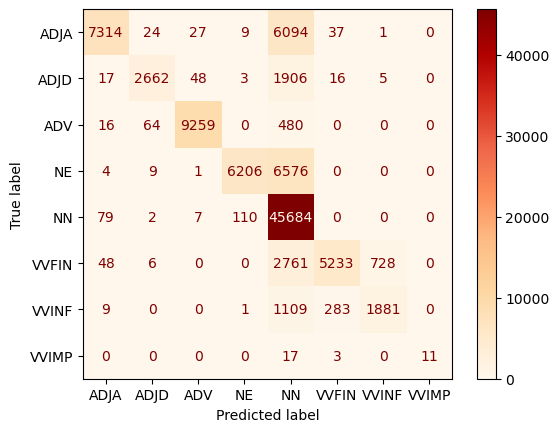

In [13]:
focus_tags = ('ADJA', 'ADJD', 'ADV', 'NE', 'NN', 'VVFIN', 'VVINF', 'VVIMP')
cm = confusion_matrix(test.pos, predicted, labels=focus_tags)
ConfusionMatrixDisplay(cm, display_labels=focus_tags).plot(cmap='OrRd');

Auffallend ist eine Spalte, mit zahlreichen Fehlern, bei denen das Lernverfahren `NN` vorhergesagt hat. Hier handelt es sich mutmaßlich zu einem großen Teil um unbekannte Wörter. Im nächsten Schritt gilt es nun also, Wortarten für solche unbekannten Wörter zu erraten.

### Präfix- und Suffixmerkmale

Die Wortart eines unbekannten Wortes lässt sich am ehesten aus der Endung (Suffix der letzten $k$ Zeichen, z.B. _-bares_) erraten, sowie teilweise auch aus dem Wortanfang (z.B. _ge-_). Wie viele Zeichen $k$ zu berücksichtigen sind, kann nur empirisch durch Experimente mit verschiedenen Parametereinstellungen ermittelt werden.

Wir könnten nun zusätzliche Spalten mit den jeweiligen Präfixen und Suffixen in unseren Datentabellen ergänzen (evtl. auch zu Kleinschreibung normalisiert) und darauf einen `OneHotEncoder` anwenden.

In [14]:
tmp = test.copy()
tmp['suff4'] = tmp.word.str.lower().str[-4:]
tmp

,sent,tok,word,pos,suff4
0,25001,1,Der,ART,der
1,25001,2,Vertreter,NN,eter
2,25001,3,der,ART,der
3,25001,4,Brandt-Witwe,NN,itwe
4,25001,5,sah,VVFIN,sah
...,...,...,...,...,...
222698,37498,2,steigen,VVFIN,igen
222699,37498,3,/,$(,/
222700,37499,1,Weniger,PIAT,iger
222701,37499,2,Stellen,NN,llen


Hier nützen wir stattdessen wieder den `CountVectorizer` mit einer geeigneten Tokenizer-Funktion (die alle gewünschten Suffixe und Präfixe zurückliefert) und der voreingestellten Normalisierung zu Kleinschreibung. Wichtig ist, dass Präfix und Suffix der gleichen Länge unterschieden werden!

In [15]:
def get_prefix_suffix(word):
    l = len(word)
    res = []
    for k in range(2, 5):
        if l > k:
            res.append("-" + word[-k:])
    for k in range(2, 4):
        if l > k:
            res.append(word[:k] + "-")
    return(res)

print(get_prefix_suffix(test.word[0]))
print(get_prefix_suffix(test.word[1]))

['-er', 'De-']
['-er', '-ter', '-eter', 'Ve-', 'Ver-']


Sinnvoll sind vor allem Affixe, die häufig genug vorkommen, um zuverlässige Informationen zu liefern. Wir zeigen hier zunächst, welche Affixe bei $f\ge 500$ verwendet werden. Für die tatsächliche Merkmalsextraktion verwenden wir dann einen weitaus niedrigeren Schwellenwert (der auch von der Länge $k$ des Affix abhängig gemacht werden könnte).

In [16]:
affix_vectorizer = CountVectorizer(tokenizer=get_prefix_suffix, min_df=500)
affix_vectorizer.fit(train.word)
print(" ".join(affix_vectorizer.get_feature_names_out()))

/opt/anaconda3/envs/Teaching/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


-00 -abe -aben -ach -acht -aft -ag -age -agen -agte -ahr -al -alen -an -and -ang -ann -ar -ark -as -at -aten -atte -au -aus -aß -be -ben -ber -bt -ch -che -chen -cher -cht -chte -ck -de -den -der -dern -dt -dung -eben -eder -ef -egen -ehen -ehr -eht -ei -eich -eien -eil -ein -eine -eit -el -elt -em -en -end -ende -ene -enen -enn -ens -ent -er -ere -eren -ern -ers -ert -erte -es -ese -et -ete -eten -etzt -fe -fen -ft -ge -gen -ger -gt -gte -gung -haft -he -heit -hen -her -hl -hmen -hr -hre -hren -hrer -ht -hte -hten -ich -iche -icht -ie -ien -ier -iert -iese -ig -ige -igen -iger -igt -ik -il -in -ind -ine -inem -inen -iner -ines -ion -ir -ird -is -isch -ise -it -iten -itik -keit -ken -kt -land -ld -le -len -ler -lich -ll -lle -llen -ls -lt -lte -lten -lung -mber -me -men -mer -mmen -mt -nd -nde -nden -nder -ne -nem -nen -ner -nes -ng -ngen -nn -nnen -ns -nt -nte -nten -nter -nung -nz -och -oll -om -on -onen -or -rch -rd -rde -rden -re -ren -rer -rk -rn -rs -rt -rte -rten -rung -sch -sch

In [17]:
affix_vectorizer = CountVectorizer(tokenizer=get_prefix_suffix, min_df=20)
X_affix = affix_vectorizer.fit_transform(train.word)
testX_affix = affix_vectorizer.transform(test.word)
X_affix.shape

(449285, 3807)

Schließlich trainieren wir eine SVM mit der kombinierten Merkmalsmatrix.

In [18]:
X = sp.sparse.hstack([X_wf, X_affix])
testX = sp.sparse.hstack([testX_wf, testX_affix])

In [19]:
clf = LinearSVC()
%time clf.fit(X, train.pos)
%time clf.score(testX, test.pos)

CPU times: user 57 s, sys: 98.9 ms, total: 57.1 s
Wall time: 57.2 s
CPU times: user 178 ms, sys: 14.7 ms, total: 192 ms
Wall time: 192 ms


0.908663107367211

### Weitere Merkmale

> **Aufgabe:** Extrahieren Sie spezifische Merkmale wie Groß-/Kleinschreibung, „Token besteht nur aus Ziffern“, „Token enthält keine Buchstaben“, „Bindestrich am Wortende“, Satzanfang, usw. als dicht besetzte Binärmatrix.  Denken Sie sich auch weitere Merkmale aus, die für die Wortartenerkennung nützlich sein könnten.  Fügen Sie die zusätzlichen Merkmale dann an die bisherige Merkmalsmatrix an.  Können Sie damit die Genauigkeit des Unigramm-Taggers verbessern?  

Solche spezifischen Merkmale können am besten mit einer eigenen Python-Funktion extrahiert werden. Dabei handelt es sich überwiegend um binäre Merkmale, z.B.: Groß-/Kleinschreibung, nur Ziffern, enthält keine Buchstaben (oder Ziffern), nur Großbuchstaben (oft eine Abkürzung), Token am Satzanfang (bzw. Satzende), Bindestrich am Wortende (Hinweis auf `TRUNC`). Mit solchem _feature engineering_ kann gezielt Information in das Lernverfahren eingebracht werden, die nach unserem linguistischen Verständnis relevant sein dürfte.

Wir extrahieren alle Merkmale als (dicht besetzte) $\{0, 1\}$-Matrix. Alternativ könnten wir auch jeweils eine Liste aller vorliegenden Merkmale erstellen und mit einem CountVectorizer übersetzen.  Unsere Lösung hat den Vorteil, dass sie nicht erst „trainiert“ werden muss, da die Merkmale schon im Voraus feststehen.  Wir beschränken uns hier auf Merkmale, die sich leicht identifizieren lassen.

In [20]:
def get_other_features(df, test=False):
    res = pd.DataFrame({
        'word': df.word,
        'upper': df.word.str.match(r'[A-ZÄÖÜ]'),
        'allcaps': df.word.str.fullmatch(r'[A-ZÄÖÜ]+'),
        'digits': df.word.str.fullmatch(r'-?[0-9][0-9.,]*'),
        'noalpha': ~df.word.str.contains(r'[a-zäöü]', flags=re.IGNORECASE),
        'noalnum': ~df.word.str.contains(r'[0-9a-zäöü]', flags=re.IGNORECASE),
        'atstart': df.tok == 1,
        'trunc': df.word.str.endswith('-'),
        'long': df.word.str.len() >= 15,
    })
    if test:
        return res
    else:
        return res.iloc[:, 1:].to_numpy(dtype=np.float64)

get_other_features(train[6355:6377], test=True)

,word,upper,allcaps,digits,noalpha,noalnum,atstart,trunc,long
6355,Fahning,True,False,False,False,False,True,False,False
6356,möchte,False,False,False,False,False,False,False,False
6357,zusätzlich,False,False,False,False,False,False,False,False
6358,den,False,False,False,False,False,False,False,False
6359,Platz,True,False,False,False,False,False,False,False
6360,über,False,False,False,False,False,False,False,False
6361,Verkehrsflächen,True,False,False,False,False,False,False,True
6362,für,False,False,False,False,False,False,False,False
6363,Behausungen,True,False,False,False,False,False,False,False
6364,nutzen,False,False,False,False,False,False,False,False


Nun können wir unsere Trainings- und Testdaten ergänzen …

In [21]:
X_other = get_other_features(train)
X = sp.sparse.hstack([X_wf, X_affix, X_other])

testX_other = get_other_features(test)
testX = sp.sparse.hstack([testX_wf, testX_affix, testX_other])

… und unsere SVM erneut trainiern und evaluieren.

In [22]:
clf = LinearSVC()
%time clf.fit(X, train.pos)
%time clf.score(testX, test.pos)

CPU times: user 45.4 s, sys: 95.9 ms, total: 45.5 s
Wall time: 45.5 s
CPU times: user 176 ms, sys: 17.1 ms, total: 193 ms
Wall time: 193 ms


0.926022550212615

Durch die zusätzlichen Merkmale gewinnen wir tatsächlich einige Prozentpunkte Genauigkeit – und das mit recht wenig Arbeitsaufwand.

> **Frage:** Können Sie erklären, warum einige dieser Merkmale (z.B. die Markierung für den Satzanfang) von einem linearen Klassifikator (wie der hier verwendeten `LinearSVC`) nicht optimal genutzt werden? Wie könnte man angesichts dieser Erkenntnis die Ergebnisse möglicherweise noch etwas verbessern?

Information über den Satzanfang ist v.a. in Kombination mit anderen Merkmalen aussagekräftig, da insbesondere dort ein sonst kleingeschriebenes Wort (z.B. _ein_) mit großem Anfangsbuchstaben stehen kann (_Ein gutes Buch ist …_). Ein linearer Klassifikator kann solche Merkmalaskombinationen nicht ausnutzen, da jedes Merkmal lediglich ein individuelles Gewicht erhält. Ein polynomiale SVM (mit `degree=2`) könnte zwar Paare von Merkmalen berücksichtigen, ist aber für unseren großen und hochdimensionalen Trainingsdatensatz nicht effizient genug.

Sinnvoll könnte es hier sein, am Satzanfang zusätzlich zur großgeschriebenen Wortform auch die kleingeschriebene Version zu den Merkmalen hinzuzufügen (in diesem Fall würde also ein _two-hot encoding_ entstehen).  Dieser Ansatz könnte noch verfeinert werden, z.B. wird die kleingeschrieben Version nur berücksichtigt wenn sie bereits im Vokabular enthalten ist (z.B. mit $f \geq 5$) und/oder wenn die großgeschrieben Originalform ein OOV ist (damit hätten wir wieder ein _one-hot encoding_).

### Optimierung

> **Aufgabe:** Experimentieren Sie mit den Metaparametern des Lernverfahrens und der Merkmalsextraktion (z.B. OOV-Schwellenwert für Wortformen, maximale Länge der Präfixe und Suffixe, hinzufügen von weiteren spezifischen Merkmalen. Testen Sie auch andere Lernverfahren als SVM: können diese schneller trainiert werden? Denken Sie, dass eine systematische Optimierung der Metaparameter (insb. der Regularisierungsstärke) sinnvoll ist?

Vor einer Metaparameteroptimierung per Grid Search kann es hilfreich sein, durch Evaluation auf den Trainingsdaten zu überprüfen, ob die SVM bereits stark übertrainiert ist (d.h. zu hohe _variance_ aufweist) oder noch zu wenig lernen kann (d.h. sich durch starken _bias_ nicht gut an die Trainingsdaten anpassen kann). Hier liegt letztere Fall vor: auch auf den Trainingsdaten ist die Genauigkeit noch sehr schlecht und wir müssen weitere Merkmale hinzufügen, um eine deutliche Verbesserung zu erreichen!

In [23]:
clf.score(X, train.pos)

0.9402406045160644

Für Experimente mit Parametern der Merkmalsextraktion (z.B. OOV-Schwellenwert, Länge der Präfixe und Suffixe, etc.) wäre es sehr vorteilhaft, die komplette Erstellung der Merkmalsmatrix in eine Funktion zu kapseln, die dann mit verschiedenen Parametern aufgerufen werden kann. Ansonsten muss bei jedem Durchgang die kombinierte Merkmalsmatrix sowohl für die Trainings- als auch die Testdaten neu zusammengefügt werden.

Wir testen hier exemplarisch ein bag-of-words-Modell mit Schwellenwert $f\geq 2$, sowohl einzeln als auch in Kombination mit den anderen Merkmalen.

In [24]:
wf2_vectorizer = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=2)
X_wf2 = wf2_vectorizer.fit_transform([(x,) for x in train.word])
testX_wf2 = wf2_vectorizer.transform([(x,) for x in test.word])
X_wf2.shape

(449285, 22859)

In [25]:
clf = LinearSVC()
clf.fit(X_wf2, train.pos)
clf.score(testX_wf2, test.pos)

0.8849229691562305

In [26]:
X2 = sp.sparse.hstack([X_wf2, X_affix, X_other])
testX2 = sp.sparse.hstack([testX_wf2, testX_affix, testX_other])
clf = LinearSVC()
clf.fit(X2, train.pos)
clf.score(testX2, test.pos)

0.931401911963467

Tatsächlich können wir mit dem niedrigeren OOV-Schwellenwert eine kleine Verbesserung erzielen, auch in Kombination mit allen anderen Merkmalen.

Schließlich testen wir als alternatives Lernverfahren noch Stochastic Gradient Descent, das im Gegensatz zur SVM sehr leicht zu implementieren ist. Mit einer geeigneten Regularisierungsstärke (die hier tatsächlich ein „kritischer“ Parameter ist) erreichen wir fast genauso gute Ergebnisse wie mit der SVM, das Training dauert aber nur wenige Sekunden.

In [27]:
%%time
clf = SGDClassifier(alpha=1e-5, max_iter=5000, n_jobs=-1)
clf.fit(X, train.pos)
clf.score(testX, test.pos)

CPU times: user 16.5 s, sys: 171 ms, total: 16.6 s
Wall time: 2.38 s


0.9236651504470079

## Oberflächenkontext

Zur kontextabhängigen Disambiguierung wollen wir nun auch die vorhergehenden und folgenden Token an jeder Stelle berücksichtigen. Dazu müssen wir satzweise vorgehen und entsprechendes _padding_ am Satzanfang und -ende hinzufügen (**Frage:** warum ist das unbedingt nötig?).

Als Beispiel bearbeiten wir zunächst einen einzelnen Satz und definieren dann eine Funktion, die wir mit den Pandas-Methoden `groupy()` und `apply()` auf alle Sätze im Korpus anwenden.

In [28]:
satz = train[train.sent == 42].copy()
satz

,sent,tok,word,pos
790,42,1,``,$(
791,42,2,Die,ART
792,42,3,Probleme,NN
793,42,4,unseres,PPOSAT
794,42,5,Landes,NN
795,42,6,sind,VAFIN
796,42,7,doch,ADV
797,42,8,weit,ADJD
798,42,9,größer,ADJD
799,42,10,als,KOKOM


Mit der Pandas-Methode `shift()` können wir die Spalten der Matrix um ein oder mehrere Token verschieben. Dabei müssen wir einen sinnvollen `fill_value` für das Padding angeben.

In [29]:
satz["L1"] = satz.word.shift(1, fill_value="")  # w_{t-1}
satz["L2"] = satz.word.shift(2, fill_value="")  # w_{t-2}
satz["R1"] = satz.word.shift(-1, fill_value="") # w_{t+1}
satz["posL1"] = satz.pos.shift(1, fill_value="*") # für Trigramm-Tagger (später)
satz["posL2"] = satz.pos.shift(2, fill_value="*")
satz

,sent,tok,word,pos,L1,L2,R1,posL1,posL2
790,42,1,``,$(,,,Die,*,*
791,42,2,Die,ART,``,,Probleme,$(,*
792,42,3,Probleme,NN,Die,``,unseres,ART,$(
793,42,4,unseres,PPOSAT,Probleme,Die,Landes,NN,ART
794,42,5,Landes,NN,unseres,Probleme,sind,PPOSAT,NN
795,42,6,sind,VAFIN,Landes,unseres,doch,NN,PPOSAT
796,42,7,doch,ADV,sind,Landes,weit,VAFIN,NN
797,42,8,weit,ADJD,doch,sind,größer,ADV,VAFIN
798,42,9,größer,ADJD,weit,doch,als,ADJD,ADV
799,42,10,als,KOKOM,größer,weit,die,ADJD,ADJD


Nun erweitern wir die Trainings- und Testdaten um diese 5 Spalten. Hier zeigt sich Pandas als sehr elegante Lösung.

In [30]:
def add_context(satz):
    satz["L1"] = satz.word.shift(1, fill_value="")  # w_{t-1}
    satz["L2"] = satz.word.shift(2, fill_value="")  # w_{t-2}
    satz["R1"] = satz.word.shift(-1, fill_value="") # w_{t+1}
    satz["posL1"] = satz.pos.shift(1, fill_value="*") # für Trigramm-Tagger (später)
    satz["posL2"] = satz.pos.shift(2, fill_value="*")
    return satz

%time train = train.groupby('sent').apply(add_context)
%time test = test.groupby('sent').apply(add_context)

CPU times: user 15.4 s, sys: 202 ms, total: 15.6 s
Wall time: 15.5 s
CPU times: user 7.37 s, sys: 145 ms, total: 7.51 s
Wall time: 7.43 s


In [31]:
test.head(20)

,sent,tok,word,pos,L1,L2,R1,posL1,posL2
0,25001,1,Der,ART,,,Vertreter,*,*
1,25001,2,Vertreter,NN,Der,,der,ART,*
2,25001,3,der,ART,Vertreter,Der,Brandt-Witwe,NN,ART
3,25001,4,Brandt-Witwe,NN,der,Vertreter,sah,ART,NN
4,25001,5,sah,VVFIN,Brandt-Witwe,der,es,NN,ART
5,25001,6,es,PPER,sah,Brandt-Witwe,anders,VVFIN,NN
6,25001,7,anders,ADV,es,sah,.,PPER,VVFIN
7,25001,8,.,$.,anders,es,,ADV,PPER
8,25002,1,Die,ART,,,Gedächtnismünze,*,*
9,25002,2,Gedächtnismünze,NN,Die,,",",ART,*


> **Aufgabe:** Extrahieren Sie passende Merkmalsvektoren für die Kontextwörtern `L1`, `L2` und `R1` (analog dazu, wie wir es oben für das jeweils zu taggende Token gemacht haben).  Da es sich um das gleiche Wortformeninventar handelt wie bei der Spalte `word`, können Sie die bereits trainierten Vectorizer weiterverwenden.  (**Frage:** Warum könnte es dennoch sinnvoll sein, eigene Vectorizer für die Kontextwörter zu trainieren? Denken Sie insbesondere an Satzanfang und -ende.)
>
> Definieren Sie dazu die Funktion `get_features(tok, word)`, die zwei Vektoren mit den Token-Nummern und den Wortformen als Argumente erwartet und daraus eine vollständige Merkmalsmatrix (mit Wortform-, Affix- und den weiteren Merkmalen) erstellt. Der Aufruf `get_features(train.tok, train.word)` sollte genau die ursprüngliche Merkmalsmatrix `X` zurückliefern. Sie können dann z.B. mit `get_features(train.tok - 1, train.L1)` Kontextmerkmale für das vorangehende Wort ermitteln.
> 
> Fügen Sie dann mit `sp.sparse.hstack()` alle Merkmalsvektoren zu einer großen Merkmalsmatrix `X2` zusammen. Erstellen Sie auch eine entsprechende Merkmalsmatrix `testX2` für die Testdaten. Bitte halten Sie sich an die vorgegebenen Variablennamen, damit der Programmcode weiter unten korrekt funktioniert. (**Tipp:** Es bietet sich an, geeignete Hilfsfunktionen zu definieren, um allzu viel Copy & Paste zu vermeiden.)

In [ ]:
def get_features(tok, word):
    return None

In [ ]:
X2 = None
testX3 = None

> **Aufgabe:** Trainieren Sie jetzt ein geeignetes Klassifikationsverfahren auf der Merkmalsmatrix mit Oberflächenkontext und evaluieren Sie es auf den Testdaten. Wie beurteilen Sie die Ergebnisse? Experimentieren Sie dabei auch mit den Metaparametern des Lernverfahrens und probieren Sie ggf. unterschiedliche Anzahlen von Kontextwörtern aus. Führen Sie schließlich eine erneute Fehleranalyse durch.
>
> **Tipp:** Wir haben oben mit Stochastic Gradient Descent (bei einer Regularisierungsstärke von $\alpha = 10^{-5}$) gute Erfahrungen gemacht. Mit diesem Lernverfahren werden Ihnen die folgenden Experimente wesentlich weniger Geduld abverlangen. (Denken Sie daran, `n_jobs=-1` anzugeben!)

## Trigramm-Tagger

Zum Schluss skizzieren wir noch die Implementierung eines Trigramm-Taggers als maschinelles Lernverfahren. Im Grunde fügen wir die zwei vorangehenden Tags mit _dummy coding_ an die Merkmalsmatrix an. Da lineare Klassifikatoren keine Merkmalskombinationen lernen können, müssen wir das Bigramm `posL2 posL1` explizit als Merkmal ergänzen. Am bequemsten ist hier ein `OneHotEncoder`, der mit oder ohne OOV konfiguriert werden kann und der sich sogar direkt auf einen DataFrame anwenden lässt (hier aber etwas günstiger mit einer Numpy-Matrix).

In [37]:
pos_vectorizer = OneHotEncoder(handle_unknown = 'infrequent_if_exist', min_frequency=5)
tmp = np.vstack([train.posL1, train.posL2, train.posL2 + " " + train.posL1]).T
X_pos = pos_vectorizer.fit_transform(tmp)
X_pos.shape

(449285, 1096)

In [38]:
tmp = np.vstack([test.posL1, test.posL2, test.posL2 + " " + test.posL1]).T
testX_pos = pos_vectorizer.transform(tmp)
testX_pos.shape

(222703, 1096)

> **Aufgabe:** Fügen Sie die zusätzlichen Merkmale zur Merkmalsmatrix `X2` hinzu (und analog für die Testdaten). Halten Sie sich wiederum an die unten vorgegebenen Variablennamen. Trainieren Sie dann eine **lineare SVM** auf der erweiterten Merkmalsmatrix und evaluieren Sie sie auf den Testdaten.
> 
> **Frage:** Sind diese Evaluationsergebnisse realistisch, d.h. können wir auf unbekannten Texten eine vergleichbare Genauigkeit erwarten wie auf den Testdaten?

In [39]:
X3 = None
testX3 = None

### Greedy Tagger

Um diesen Tagger überhaupt auf neue Eingabesätze anwenden zu können, für die im Gegensatz zu unseren Testdaten noch keine POS-Tags vorliegen, müssen wir jedes Token einzeln verarbeiten und für das nächste Token dann jeweils die POS-Kontextmerkmale an den Merkmalsvektor anhängen.  Wir definieren dazu eine Hilfsfunktion, die einen einzelnen Satz aus dem Testkorpus in dieser Form verarbeitet. Wir müssen dabei sicherstellen, dass die Matrix im CSR-Format vorliegt, um nachher leicht einzelne Merkmalsvektoren (= Zeilen) herausgreifen zu können.

In [67]:
def get_all_features(satz):
    return sp.sparse.hstack([
        get_features(satz.tok, satz.word),
        get_features(satz.tok - 1, satz.L1),
        get_features(satz.tok - 2, satz.L2),
        get_features(satz.tok + 1, satz.R1),
    ], format='csr')

Um einen Satz mit dem Greedy Tagger zu verarbeiten, erstellen wir zunächst eine Merkmalsmatrix analog zu `X2` für den Satz. Wir gehen diese Matrix dann Zeile für Zeile durch, hängen an den Merkmalsvektor die Merkmale für die vorhergehenden POS-Tags an (um einen Vektor analog zu `X3` zu erhalten) und wenden den Klassifikator auf den resultierenden Zeilenvektor an.

In [68]:
def tag_sentence(satz):
    n = satz.shape[0]
    X = get_all_features(satz) # Matrix der Oberflächenmerkmale
    tags = []
    p1 = p2 = "*"              # vorhergehende POS-Tags
    for i in range(n):
        x1 = X[i, :]
        x2 = pos_vectorizer.transform(np.array([[p1, p2, p2 + " " + p1]]))
        x = sp.sparse.hstack([x1, x2])
        tag = clf.predict(x)[0] # liefert NumPy-Array zurück
        tags.append(tag)
        p2, p1 = p1, tag
    return pd.Series(tags, index=satz.index, dtype='string')

In [ ]:
satz['tag'] = tag_sentence(satz)
satz.loc[:, ("sent", "tok", "word", "pos", "tag")]

Diese Funktion müssen wir nun auf jeden Satz der Testdaten anwenden, was deutlich länger dauern wird als bisher.

In [ ]:
%%time
predicted = test.groupby('sent').apply(tag_sentence)

Die realistisch berechnete Genauigkeit ist kaum besser als beim Tagger, der nur Oberflächenkontext genutzt hat. Daher stellt sich die Frage, ob der viel höhere Zeitaufwand gerechtfertigt ist! Vielleicht lässt sich auch ohne Sequenzmodell durch weitere Optimierungen ein hinreichend guter Tagger implementieren.

In [ ]:
print(accuracy_score(predicted, test.pos))

**Tipp:** Eine Evaluation auf den Trainingsdaten legt nahe, dass die SVM hochgradig übertrainiert ist. Möglicherweise würde eine stärkere Regularisierung oder eine geeignete Merkmalsselektion die Genauigkeit auf den Testdaten verbessern.

In [ ]:
clf.score(X3, train.pos)